In [1]:
from ophyd import EpicsSignal, EpicsSignalRO, Device, Component

from bluesky import RunEngine
from bluesky.callbacks import LiveTable, LivePlot
from bluesky.plans import count
from databroker.v2 import temp

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Hp3458A(Device):
    
    init_cmd = Component(EpicsSignal, "RUN",kind="omitted")
    readback = Component(EpicsSignalRO, "V", kind="hinted")

    def stage(self):
        self.init_cmd.put(1)
        super().stage()

    def unstage(self):
        self.init_cmd.put(0)
        super().unstage()

In [3]:
db= temp()
dmm = Hp3458A("DVM:", name="dmm")
dmm.wait_for_connection()

RE = RunEngine()
RE.subscribe(db.v1.insert)

CA.Client.Exception...............................................
    Context: "Channel: "DVM:RUN", Connecting to: 192.168.0.10:5064, Ignored: hhs-desktop:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Wed Nov 22 2023 11:59:53.744191374
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "DVM:V", Connecting to: 192.168.0.10:5064, Ignored: hhs-desktop:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Wed Nov 22 2023 11:59:53.749883675
..................................................................


0

In [4]:
RE(count([dmm],num=10000,delay=0.001))

('06ff62b8-953b-4a1e-92db-d863277e612b',)

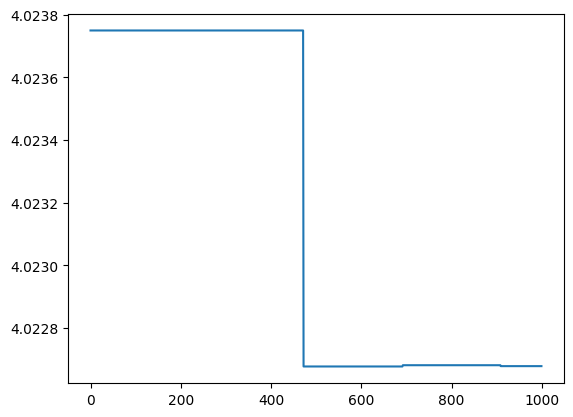

In [7]:
#  Read Measurement
run = db[-1]
position = run.primary.read().dmm_readback
df = position.to_dataframe()
df.reset_index(inplace=True)
plt.plot(df["dmm_readback"])

In [ ]:
# Exclude initial and final positions
df = df[(df['m1_readback'] != df['m1_readback'].iloc[0]) & (df['m1_readback'] != df['m1_readback'].iloc[-1])]

# Calculate the time between consecutive measurements
df['TimeDiff'] = df['time'].diff()

# Count how many times the same position is measured
df['PositionCount'] = df.groupby('m1_readback').cumcount() + 1

# Step 3: Calculate the average time between consecutive measurements
average_time = df['TimeDiff'].mean()

# Step 4: Multiply the average count by the average time to get the update rate
update_rate = (df['PositionCount'].mean() - 1) * average_time

print(f"Update rate: {np.round(1/update_rate,2)} Hz")